# Dogs Image Explortion

**The purposes of this notebook are:**

- **Practicing image handling**
- **Examine data and annotations**
- **Prepare tools for next phases**

In particular:

- Reading and showing the images with their annotations (class / boxes)
- Reviewing image size distribution
- Finding mean and std
- Creating a dataset class

In [1]:
import neptune

import torch
# torchvision: popular datasets, model architectures, and common image transformations for computer vision.
import torchvision
import torch.nn.functional as F 
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as T
from sklearn.model_selection import train_test_split

import glob
import os.path as osp
import os
import numpy as np
from PIL import Image # to read images

import xml.etree.ElementTree as ET # for parsing XML
import matplotlib.pyplot as plt # to show images
import matplotlib.patches as patches
from tqdm.notebook import tqdm
import time

%matplotlib inline

In [2]:
# neptune.init('MM-IT-DOGS/dogs-project')

In [8]:
# BASE_PATH = "/home/ishay/Documents/MDLI/dogs/data"
# IMGS_PATH = "/home/ishay/Documents/MDLI/dogs/data/Images/"
#BASE_PATH = '/home/MichaelMandelbaum/CS321/Projects/dogs/' #Michael GCP
# IMGS_PATH = BASE_PATH + "Data/Images/" #Michael GCP
BASE_PATH = "/home/ishay_telavivi/data" # Ishay GCP
IMGS_PATH = "/home/ishay_telavivi/data/Images/"

## Examine directory structure and content

In [4]:
print(os.listdir(BASE_PATH))

['Images', 'Annotation']


**Images**

In [5]:
breed_list = os.listdir(BASE_PATH + "/Images")[:5]
# breed_list = os.listdir(IMGS_PATH)

In [6]:
# Print first 5 breeds in Images
print(breed_list[:5])

['n02106030-collie', 'n02100877-Irish_setter', 'n02087046-toy_terrier', 'n02109047-Great_Dane', 'n02086910-papillon']


## Train-Test Split / DataLoader / Find mean and std

Since the data does not come split to train / test / eval, we need to create it ourselves.

In [7]:
# First create a dict of breeds and label
breed_dict = {bread:i for i, bread in enumerate(breed_list)}
breed_dict_invert = {val: key for key, val in breed_dict.items()}

In [9]:
all_filenames = []
for breed in tqdm(breed_dict):
    # Take care of each image (image+label)
#     breed_path = BASE_PATH + "/Images/" + breed
    breed_path = IMGS_PATH + breed
    for img_file_name in os.listdir(breed_path):
        img_path = breed_path + "/" + img_file_name
        all_filenames.append(img_path)

In [10]:
all_filenames[:5]

['/home/ishay_telavivi/data/Images/n02106030-collie/n02106030_17923.jpg',
 '/home/ishay_telavivi/data/Images/n02106030-collie/n02106030_16250.jpg',
 '/home/ishay_telavivi/data/Images/n02106030-collie/n02106030_5915.jpg',
 '/home/ishay_telavivi/data/Images/n02106030-collie/n02106030_8697.jpg',
 '/home/ishay_telavivi/data/Images/n02106030-collie/n02106030_16623.jpg']

In [11]:
len(all_filenames)

832

Now split the paths

In [12]:
train_eval_paths, test_paths = train_test_split(all_filenames, test_size=0.10, random_state=0)

In [13]:
train_paths, evel_paths = train_test_split(train_eval_paths, test_size=0.20, random_state=0)

In [14]:
print(len(train_paths), len(evel_paths), len(test_paths))

598 150 84


In [15]:
train_paths[:5]

['/home/ishay_telavivi/data/Images/n02109047-Great_Dane/n02109047_23058.jpg',
 '/home/ishay_telavivi/data/Images/n02100877-Irish_setter/n02100877_123.jpg',
 '/home/ishay_telavivi/data/Images/n02100877-Irish_setter/n02100877_4506.jpg',
 '/home/ishay_telavivi/data/Images/n02100877-Irish_setter/n02100877_6724.jpg',
 '/home/ishay_telavivi/data/Images/n02109047-Great_Dane/n02109047_2358.jpg']

## Create a Dataset Class

So here I used the PyTorch way as in the links. In the get_item method we need to return the image and a dict with all the 5 arguments. In the pytorch tutorial there is also "mask" but here there is no need 

With help from: https://pytorch.org/tutorials/intermediate/torchvision_tutorial.html 

and: https://medium.com/fullstackai/how-to-train-an-object-detector-with-your-own-coco-dataset-in-pytorch-319e7090da5

## MM: the following is the only change I made

In [16]:
# The purpose of the Dataset class is to allow handling the iamges more easily.
class DogsDS(Dataset):
    def __init__(self, image_paths, annot_dir ,breed_dict, transform=None):
        
        """
        The init function generates a list of the images, and a dict with three keys for labels, boxes and
        size.
        """
        
        self.paths = image_paths
        self.annot_dir = annot_dir
        self.breed_dict = breed_dict
        self.transform = transform
        # Here we store the data segments (image, class, box)
        self.images = []
        self.annot_dict = {}
        
        # Iterate over all classes and images and collect to lists
        label_indices = []
        
        # MM add the following as a global parameter
#         boxes = []
        self.boxes = []

        size_list = []
        
        for path in tqdm(self.paths):
            #print(breed)
            # Split the path by "/"
            split_path = path.split("/")
            # We get something like: ['home',....,'Images','n02106550-Rottweiler','n02106550_5710.jpg']

            # Get the label index
            breed = split_path[-2]
            label_idx = self.breed_dict[breed]
            label_indices.append(label_idx)
            
            # img_image = io.imread(img_path)
            img_image = Image.open(path)
            # If I don't clode the file I get "Too many open files exception", and if I close the file
            # without a copy, I can't use it
            self.images.append(img_image.copy())
            img_image.close()

            # Now the box
            img_file_name = split_path[-1]
            annot_name = img_file_name.split(".")[0]
            annot_path = self.annot_dir + breed + "/" + annot_name
            # Extract the box attributes from the path
            tree = ET.parse(annot_path) # init parser for file given
            root = tree.getroot() # idk what's it but it's from documentation
            objects = root.findall('object') # finding all dogs. An array
            for o in objects:
                bndbox = o.find('bndbox') # reading border coordinates
                xmin = int(bndbox.find('xmin').text)
                ymin = int(bndbox.find('ymin').text)
                xmax = int(bndbox.find('xmax').text)
                ymax = int(bndbox.find('ymax').text)
            
            box = (xmin, ymin, xmax, ymax)
            
            # MM
#             boxes.append(box)
            self.boxes.append(box)
            
            
            # Now the size
            sizes = root.findall('size') # An array
            for size in sizes:
                width = int(size.find('width').text)
                height = int(size.find('height') .text)
            size_list.append((width, height))

            self.annot_dict["boxes"] = self.boxes #boxes
            self.annot_dict["labels"] = label_indices
            self.annot_dict["sizes"] = size_list
        
        # MM Now I added the transformations to tensor here, and deleted the same in getitem
        self.boxes = torch.as_tensor(self.boxes, dtype=torch.float32)
        self.annot_dict["labels"] = torch.as_tensor(self.annot_dict["labels"], dtype=torch.int64)
        
        #MM 5.9.2020
#         self.boxes = self.boxes.reshape(-1, 4)
                    
    def __len__(self):
        """
        Total number of samples in the dataset
        """
        return len(self.images)
    
    
    def __getitem__(self, index):
        """ 
        Get a sample from the dataset.
        input: index
        returns: a tuple of: image, label(index), box(tuple)
                 for example: (<image..>, 3, (114, 20, 298, 357))
        """
        # If dataset is preloaded
        image = self.images[index]
        # Number of objects in the image. I have only 1 in all images. Basically for OD with more than one 
        # object in an image, we need to iterate this code as in the pytorch example
        num_objs = 1
        
        # Bounding boxes for objects
        # In coco format, bbox = [xmin, ymin, width, height]
        # In pytorch, the input should be [xmin, ymin, xmax, ymax]
        
        # MM The following are not required anymore
#         xmin = self.annot_dict["boxes"][index][0]
#         ymin = self.annot_dict["boxes"][index][1]
#         xmax = self.annot_dict["boxes"][index][2]
#         ymax = self.annot_dict["boxes"][index][3]
        
#         boxes = torch.as_tensor([xmin, ymin, xmax, ymax], dtype=torch.float32)

        # MM as we already have it from the init, we just need to get the correct box by the index
        out_boxes = self.boxes[index]
        
        # Must have a 2D tensor
        # MM removed
#         labels = torch.as_tensor((self.annot_dict["labels"][index],), dtype=torch.int64)
        
        # MM same here, lables is already a tensor
        labels = self.annot_dict["labels"][index]
        
        
        ## Tensorise img_id
        image_id = torch.tensor([index])
        ## Box size
        box_size = self.annot_dict["sizes"][index][0] * self.annot_dict["sizes"][index][1]
        area = torch.as_tensor((box_size,), dtype=torch.float32)
        
        # Iscrowd - this is a binary argument to indicate (when there are several objects) if the object is
        # croud (zero) or true object (one). In our example of course it is 0
        iscrowd = torch.zeros((num_objs,), dtype=torch.int64)
        
        # May use transform function to transform samples
        # e.g., random crop, whitening
        if self.transform is not None:
            image = self.transform(image)
        # return image and label
        return image, {"labels": labels, 
                       "boxes": out_boxes, #boxes,
                       "image_id": image_id,
                       "area": area,
                       "iscrowd": iscrowd}#, "size": size}
#         return image, image


In [17]:
annotations_paths = BASE_PATH + "/Annotation/"
# annotations_paths = BASE_PATH + "Data/Annotation/" #Michael GCP

In [18]:
annotations_paths

'/home/ishay_telavivi/data/Annotation/'

In [19]:
# Must at least transform to tensor
transform = T.Compose([   
                T.Resize((224,224)),
                T.ToTensor(),
            ])

In [20]:
import torch.multiprocessing
torch.multiprocessing.set_sharing_strategy('file_system')

In [21]:
# If I run the following cell on all the data on my computer it colapses, but on the cloud it's OK.

In [22]:
train_ds = DogsDS(train_paths, annotations_paths, breed_dict, transform)
eval_ds = DogsDS(evel_paths, annotations_paths, breed_dict, transform)
test_ds = DogsDS(test_paths, annotations_paths, breed_dict, transform)

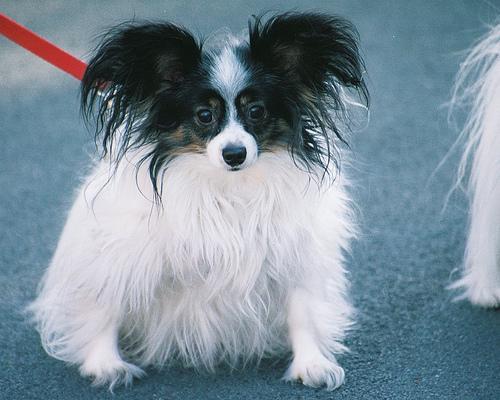

In [23]:
# Now examine one sample
# Examine image
sample_idx = 302
# Image
sample_image = train_ds.images[sample_idx]
sample_image

In [24]:
# Examine label
sample_label = train_ds.annot_dict["labels"][sample_idx]
sample_label

tensor(4)

In [25]:
breed_dict

{'n02106030-collie': 0,
 'n02100877-Irish_setter': 1,
 'n02087046-toy_terrier': 2,
 'n02109047-Great_Dane': 3,
 'n02086910-papillon': 4}

In [26]:
breed_dict_invert

{0: 'n02106030-collie',
 1: 'n02100877-Irish_setter',
 2: 'n02087046-toy_terrier',
 3: 'n02109047-Great_Dane',
 4: 'n02086910-papillon'}

In [27]:
breed_dict_invert[int(sample_label)]

'n02086910-papillon'

In [28]:
# Examine size
sample_size = train_ds.annot_dict["sizes"][sample_idx]
sample_size

(500, 400)

In [29]:
# Examine box
sample_box = train_ds.annot_dict["boxes"][sample_idx]
sample_box

(36, 14, 370, 387)

In [30]:
xmin, ymin, xmax, ymax = sample_box[0], sample_box[1], sample_box[2], sample_box[3]

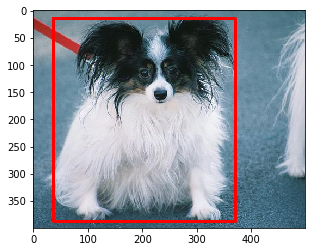

In [31]:
# Check that this is the right box:
plt.imshow(sample_image)
plt.plot([xmin, xmax, xmax, xmin, xmin], [ymin, ymin, ymax, ymax, ymin],  linewidth=3, c="r")

**COOL!**

In [32]:
# Get the tensoe image
train_ds[100][0]

tensor([[[0.8078, 0.8078, 0.8118,  ..., 0.9216, 0.9294, 0.9294],
         [0.8039, 0.8000, 0.8039,  ..., 0.9137, 0.9176, 0.9176],
         [0.8118, 0.8078, 0.8118,  ..., 0.9176, 0.9216, 0.9216],
         ...,
         [0.2549, 0.2627, 0.2706,  ..., 0.2667, 0.3255, 0.3216],
         [0.2510, 0.2745, 0.2471,  ..., 0.2706, 0.3922, 0.4431],
         [0.2196, 0.2471, 0.1961,  ..., 0.3020, 0.3922, 0.3804]],

        [[0.8824, 0.8824, 0.8863,  ..., 0.9725, 0.9725, 0.9725],
         [0.8784, 0.8745, 0.8784,  ..., 0.9647, 0.9608, 0.9608],
         [0.8863, 0.8824, 0.8863,  ..., 0.9686, 0.9647, 0.9647],
         ...,
         [0.4549, 0.4627, 0.4706,  ..., 0.4667, 0.5059, 0.4941],
         [0.4510, 0.4745, 0.4471,  ..., 0.4667, 0.5333, 0.5765],
         [0.4196, 0.4471, 0.3961,  ..., 0.4980, 0.5137, 0.4824]],

        [[0.9373, 0.9373, 0.9412,  ..., 0.9961, 0.9961, 0.9961],
         [0.9333, 0.9294, 0.9333,  ..., 0.9882, 0.9843, 0.9843],
         [0.9412, 0.9373, 0.9412,  ..., 0.9922, 0.9882, 0.

In [33]:
train_ds[100][1]['labels']

tensor(0)

In [34]:
train_ds[100][1]["boxes"]

tensor([148.,  17., 472., 373.])

In [35]:
train_ds[100][1]["area"]

tensor([187000.])

In [36]:
train_ds[100][1]["iscrowd"]

tensor([0])

In [37]:
train_ds[100][1]["image_id"]

tensor([100])

## DataLoader

In [83]:
# The batch_size is 1 only for examining the data. It should be higher of course
train_loader = DataLoader(train_ds, batch_size=8, num_workers=0, shuffle=True)
eval_loader = DataLoader(eval_ds, batch_size=1, num_workers=0, shuffle=True)
test_loader = DataLoader(test_ds, batch_size=1, num_workers=0, shuffle=True)

In [84]:
len(train_ds)

598

In [85]:
len(train_loader)

75

In [86]:
# Use GPU if available, otherwise stick with cpu
use_cuda = torch.cuda.is_available()
torch.manual_seed(123)
device = torch.device("cuda" if use_cuda else "cpu")
print(device)

cuda


## The Model

In [87]:
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

def get_model_instance_segmentation(num_classes):
    # load an instance segmentation model pre-trained pre-trained on COCO
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
    # get number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    print("in_features", in_features)
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    return model

In [88]:
# Need to add one class as a background
num_classes = len(breed_list) + 1
num_epochs = 2
model = get_model_instance_segmentation(num_classes)

# move model to the right device
model.to(device)

in_features 1024


FasterRCNN(
  (transform): GeneralizedRCNNTransform()
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(original_name=FrozenBatchNorm2d)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(original_name=FrozenBatchNorm2d)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(original_name=FrozenBatchNorm2d)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(original_name=FrozenBatchNorm2d)
          (relu): ReLU(inplace=True)
          (downsample): Sequential(
       

In [89]:
# parameters
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)

In [90]:
len_dataloader = len(train_loader)

In [91]:
len_dataloader

75

In [92]:
annotations = train_ds.annot_dict

In [93]:
annotations.keys()

dict_keys(['boxes', 'labels', 'sizes'])

In [94]:
# # Here I print the annotation dictionary with the 5 tensors per sample
# model.train()
# i = 0    
# for imgs, annotations in train_loader:
#     imgs = imgs.to(device)
#     annotations = [{k: v.to(device) for k, v in annotations.items()}]
#     print(annotations)

In [95]:
# #Set Neptune params
# EXP_NAME = 'Resnet50 FastRCNN classification+bbox'
# TAGS = ['classification', 'bbox']
# # DESC = 'VGG16 + H flip take 2 + checkpoints + early stopping'

# neptune.create_experiment(name=EXP_NAME, 
#                           #params=PARAMS,
#                           tags=TAGS,
#                          )#description=DESC)

In [96]:
# CHECKPOINTS_DIR = BASE_PATH + "Artifacts/" #Michael GCP
# CHECKPOINTS_DIR

In [97]:
num_epochs = 1

In [98]:
#https://github.com/pytorch/vision/blob/master/references/detection/engine.py

for epoch in range(num_epochs):
    model.train()
    i = 0    
    for imgs, annotations in train_loader:
        i += 1
        print(i)
#         imgs = imgs.to(device) - This creates a list of tesors, where the all the tensors are in [0]
        imgs = list(img.to(device) for img in imgs)
        annotations = [{k: v.to(device) for k, v in annotations.items()} for annot in annotations]
#         annotations = [{k: v.to(device) for k, v in annotations.items()}]

#         print(annotations)
#         print(imgs.size())
#         curr_annot_b1 = annotations
#         curr_annot_b2 = annotations

#         annot_list = []
#         d = annotations[0]
#         d1 = {}
#         d2 = {}

#         for key in d:
#         #     for i in range(len(d[key])):
#         #         print(i)
#             d1[key] = d[key][0]
#             d2[key] = d[key][1]

#         annot_list = [annotations[0], annotations[0]]
#         print(annot_list)
        
#         loss_dict = model(imgs, annot_list)

        loss_dict = model(imgs, annotations)
        losses = sum(loss for loss in loss_dict.values())

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()
        
#         neptune.log_metric('loss', losses)
#         neptune.log_metric('test_acc', test_acc)
#         neptune.log_metric('train_acc', train_acc)

        print(f'Iteration: {i}/{len_dataloader}, Loss: {losses}')

1


IndexError: list index out of range

In [ ]:
neptune.stop()